In [2]:
%load_ext autoreload
%autoreload 2
# imports

import pacsltk.pacs_util as pacs_util
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

pacs_util.prepare_matplotlib_cycler()

# To avoid type 3 fonts: http://phyletica.org/matplotlib-fonts/
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import parse_util

import os
import glob
from datetime import timedelta

import pacsltk
print(pacsltk.__version__)

0.2.0


In [3]:
# Config paths
EXP_CONFIG_NAME_DEFAULT = 'bench1_sleep_rand2_1000_200'
exp_config_name = os.getenv("EXP_CONFIG_NAME", EXP_CONFIG_NAME_DEFAULT)
exp_file = f"configs/{exp_config_name}.json"
overview_file_glob = f"results/{exp_config_name}/overview*.csv"
overview_file = glob.glob(overview_file_glob)[0]

print('config name:', exp_config_name)
print('overview file:', overview_file)
print('experiment file:', exp_file)

config name: bench1_sleep_rand2_1000_200
overview file: results/bench1_sleep_rand2_1000_200/overview_res-2021-02-27_16-47-11.csv
experiment file: configs/bench1_sleep_rand2_1000_200.json


In [4]:
# get overview
overview_df = pd.read_csv(overview_file, index_col=0, parse_dates=True)
overview_df.head(8)

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins
0,1,1,res-2021-02-25_17-23-32,bench1_sleep_rand2_1000_200,bench1,False,60
1,1,2,res-2021-02-25_18-24-16,bench1_sleep_rand2_1000_200,bench1,False,60
2,1,3,res-2021-02-25_19-24-47,bench1_sleep_rand2_1000_200,bench1,False,60
3,1,5,res-2021-02-25_20-25-14,bench1_sleep_rand2_1000_200,bench1,False,60
4,1,7,res-2021-02-25_21-25-36,bench1_sleep_rand2_1000_200,bench1,False,60
5,1,10,res-2021-02-25_22-25-54,bench1_sleep_rand2_1000_200,bench1,False,60
6,1,15,res-2021-02-25_23-26-10,bench1_sleep_rand2_1000_200,bench1,False,60
7,1,20,res-2021-02-26_00-26-27,bench1_sleep_rand2_1000_200,bench1,False,60


In [5]:
batch_seconds = 300

# func used on each batch (part of a single experiment logs)
parse_cols_funcs = {
    'conc_window_average': lambda df: df['conc_window_average'].mean(),
    'average_ready_count': lambda df: df['ready_count'].mean(),
}

# func used on each batch (part of a single experiment logs)
parse_req_cols_funcs = {
    'client_elapsed_time': lambda df: df['client_elapsed_time'].mean(),
    'lambda_over_n': lambda df: df['lambda_over_n'].mean(),
}

parse_res = []
for res_name in tqdm(overview_df['res_name']):
    res_logger_file = f"results/{exp_config_name}/{res_name}_logger.csv"
    df = parse_util.parse_logger_file(res_logger_file)
    parse_cols_res = parse_util.parse_batch_custom_funcs(df, batch_seconds, parse_cols_funcs)
    
    res_reqs_file = f"results/{exp_config_name}/{res_name}_reqs.csv"
    df_req = parse_util.parse_reqs_file(res_reqs_file)
    parse_req_res = parse_util.parse_batch_custom_funcs(df_req, batch_seconds, parse_req_cols_funcs)

    parse_cols_res.update(parse_req_res)

    parse_res.append(parse_cols_res)

parse_res_df = pd.DataFrame(data=parse_res)
parse_res_df.head()

  0%|          | 0/48 [00:00<?, ?it/s]

,conc_window_average_mean,conc_window_average_var,conc_window_average_se,conc_window_average_ci,average_ready_count_mean,average_ready_count_var,average_ready_count_se,average_ready_count_ci,client_elapsed_time_mean,client_elapsed_time_var,client_elapsed_time_se,client_elapsed_time_ci,lambda_over_n_mean,lambda_over_n_var,lambda_over_n_se,lambda_over_n_ci
0,0.579014,0.000356,0.005692,0.011157,2.121956,0.018384,0.040881,0.080127,1.239458,0.000202,0.004288,0.008404,0.480077,0.000540,0.007004,0.013728
1,0.644103,0.000168,0.003905,0.007654,3.921273,0.024550,0.047242,0.092594,1.246652,0.000079,0.002686,0.005265,0.517322,0.000487,0.006655,0.013044
2,0.666646,0.000161,0.003828,0.007503,5.701704,0.046842,0.065256,0.127902,1.241273,0.000136,0.003515,0.006889,0.532036,0.000480,0.006607,0.012949
3,0.680908,0.000091,0.002884,0.005652,9.058556,0.043287,0.062731,0.122953,1.227616,0.000028,0.001592,0.003120,0.554844,0.000165,0.003875,0.007595
4,0.692609,0.000040,0.001906,0.003736,12.335257,0.066347,0.077663,0.152220,1.216370,0.000005,0.000641,0.001256,0.569285,0.000146,0.003643,0.007141


In [6]:
orig_overview_parsed_df = pd.concat([overview_df, parse_res_df], axis=1)
orig_overview_parsed_df.head()

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins,conc_window_average_mean,conc_window_average_var,conc_window_average_se,...,average_ready_count_se,average_ready_count_ci,client_elapsed_time_mean,client_elapsed_time_var,client_elapsed_time_se,client_elapsed_time_ci,lambda_over_n_mean,lambda_over_n_var,lambda_over_n_se,lambda_over_n_ci
0,1,1,res-2021-02-25_17-23-32,bench1_sleep_rand2_1000_200,bench1,False,60,0.579014,0.000356,0.005692,...,0.040881,0.080127,1.239458,0.000202,0.004288,0.008404,0.480077,0.000540,0.007004,0.013728
1,1,2,res-2021-02-25_18-24-16,bench1_sleep_rand2_1000_200,bench1,False,60,0.644103,0.000168,0.003905,...,0.047242,0.092594,1.246652,0.000079,0.002686,0.005265,0.517322,0.000487,0.006655,0.013044
2,1,3,res-2021-02-25_19-24-47,bench1_sleep_rand2_1000_200,bench1,False,60,0.666646,0.000161,0.003828,...,0.065256,0.127902,1.241273,0.000136,0.003515,0.006889,0.532036,0.000480,0.006607,0.012949
3,1,5,res-2021-02-25_20-25-14,bench1_sleep_rand2_1000_200,bench1,False,60,0.680908,0.000091,0.002884,...,0.062731,0.122953,1.227616,0.000028,0.001592,0.003120,0.554844,0.000165,0.003875,0.007595
4,1,7,res-2021-02-25_21-25-36,bench1_sleep_rand2_1000_200,bench1,False,60,0.692609,0.000040,0.001906,...,0.077663,0.152220,1.216370,0.000005,0.000641,0.001256,0.569285,0.000146,0.003643,0.007141


# Make Workload Plots

In [7]:
# list all available columns
orig_overview_parsed_df.columns

Index(['target', 'rps', 'res_name', 'request_func', 'workload_name', 'is_rps',
       'exp_time_mins', 'conc_window_average_mean', 'conc_window_average_var',
       'conc_window_average_se', 'conc_window_average_ci',
       'average_ready_count_mean', 'average_ready_count_var',
       'average_ready_count_se', 'average_ready_count_ci',
       'client_elapsed_time_mean', 'client_elapsed_time_var',
       'client_elapsed_time_se', 'client_elapsed_time_ci',
       'lambda_over_n_mean', 'lambda_over_n_var', 'lambda_over_n_se',
       'lambda_over_n_ci'],
      dtype='object')

In [8]:
# filter for some values
plot_targets = [1,2,5,10]
overview_parsed_df = orig_overview_parsed_df[orig_overview_parsed_df['target'].isin(plot_targets)]
overview_parsed_df.head()

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins,conc_window_average_mean,conc_window_average_var,conc_window_average_se,...,average_ready_count_se,average_ready_count_ci,client_elapsed_time_mean,client_elapsed_time_var,client_elapsed_time_se,client_elapsed_time_ci,lambda_over_n_mean,lambda_over_n_var,lambda_over_n_se,lambda_over_n_ci
0,1,1,res-2021-02-25_17-23-32,bench1_sleep_rand2_1000_200,bench1,False,60,0.579014,0.000356,0.005692,...,0.040881,0.080127,1.239458,0.000202,0.004288,0.008404,0.480077,0.000540,0.007004,0.013728
1,1,2,res-2021-02-25_18-24-16,bench1_sleep_rand2_1000_200,bench1,False,60,0.644103,0.000168,0.003905,...,0.047242,0.092594,1.246652,0.000079,0.002686,0.005265,0.517322,0.000487,0.006655,0.013044
2,1,3,res-2021-02-25_19-24-47,bench1_sleep_rand2_1000_200,bench1,False,60,0.666646,0.000161,0.003828,...,0.065256,0.127902,1.241273,0.000136,0.003515,0.006889,0.532036,0.000480,0.006607,0.012949
3,1,5,res-2021-02-25_20-25-14,bench1_sleep_rand2_1000_200,bench1,False,60,0.680908,0.000091,0.002884,...,0.062731,0.122953,1.227616,0.000028,0.001592,0.003120,0.554844,0.000165,0.003875,0.007595
4,1,7,res-2021-02-25_21-25-36,bench1_sleep_rand2_1000_200,bench1,False,60,0.692609,0.000040,0.001906,...,0.077663,0.152220,1.216370,0.000005,0.000641,0.001256,0.569285,0.000146,0.003643,0.007141


In [9]:
rps_ticks = overview_parsed_df['rps'].unique()

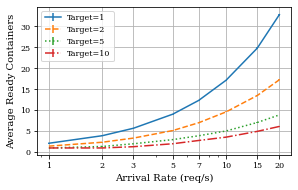

In [49]:
plt.figure(figsize=(4,2.5))
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['average_ready_count_mean'])
    plt.errorbar(sub_df['rps'], sub_df['average_ready_count_mean'], yerr=sub_df['average_ready_count_ci'], label=f"Target={target_value}")

plt.gca().set_xscale('log')
plt.xticks(rps_ticks, rps_ticks)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Ready Containers")
parse_util.tmp_fig_save('01_average_ready_containers_vs_arrival_rate', exp_config_name)

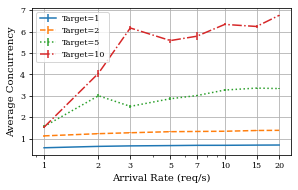

In [50]:
plt.figure(figsize=(4,2.5))
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['conc_window_average_mean'])
    plt.errorbar(sub_df['rps'], sub_df['conc_window_average_mean'], yerr=sub_df['conc_window_average_ci'], label=f"Target={target_value}")

plt.gca().set_xscale('log')
plt.xticks(rps_ticks, rps_ticks)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Concurrency")
parse_util.tmp_fig_save('02_conc_window_average_vs_arrival_rate', exp_config_name)

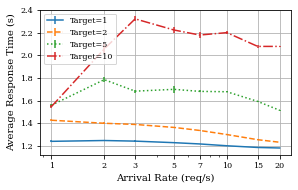

In [51]:
plt.figure(figsize=(4,2.5))
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['conc_window_average_mean'])
    plt.errorbar(sub_df['rps'], sub_df['client_elapsed_time_mean'], yerr=sub_df['client_elapsed_time_ci'], label=f"Target={target_value}")

plt.gca().set_xscale('log')
plt.xticks(rps_ticks, rps_ticks)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Response Time (s)")
parse_util.tmp_fig_save('03_average_resp_time_vs_arrival_rate', exp_config_name)

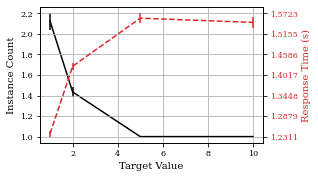

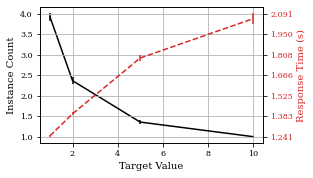

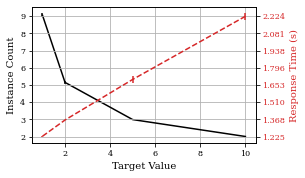

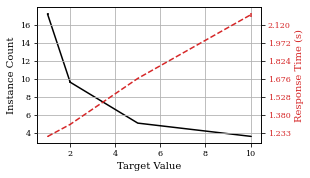

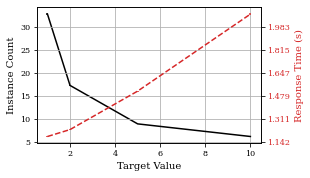

In [64]:
# let's see if we can make plots for effect of CC
from matplotlib import ticker

for plot_arrival_rate in [1,2,5,10,20]:
    sub_overview_df = overview_parsed_df[overview_parsed_df['rps'] == plot_arrival_rate]

    plt.figure(figsize=(4,2.5))
    color = 'k'
    ax1 = plt.gca()
    ax1.errorbar(sub_overview_df['target'], sub_overview_df['average_ready_count_mean'], yerr=sub_overview_df['average_ready_count_ci'], color=color)
    ax1.set_xlabel('Target Value')
    ax1.set_ylabel('Instance Count', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid(True, axis='x')

    color = 'tab:red'
    ax2 = plt.gca().twinx()
    ax2.errorbar(sub_overview_df['target'], sub_overview_df['client_elapsed_time_mean'], yerr=sub_overview_df['client_elapsed_time_ci'], ls='--', color=color)
    ax2.set_ylabel('Response Time (s)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid(None)

    # aligning ticks for grids
    l = ax1.get_ylim()
    l2 = ax2.get_ylim()
    f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
    ticks = f(ax1.get_yticks())
    ax2.yaxis.set_major_locator(ticker.FixedLocator(ticks))

    parse_util.tmp_fig_save(f'04_inst_count_resp_time_target_arrival_{plot_arrival_rate}', exp_config_name)